In [1]:
from helpers import write_result, load_malawi_data, split_data, SAVE_PATH

from pathlib import Path

import pandas as pd
import numpy as np

from multiprocessing import Pool

path_to_feature_sets = Path('/home/selker/eop/eop/select_predictors/2019')

from pathlib import Path
from multiprocessing import Pool

import numpy as np
import pandas as p
from opt_targeted_transfers import (
    ConditionalTargetedTransfers,
    HybridTargetedTransfers,
    UnconditionalTargetedTransfers,
    GapTargetedTransfers,
    OracleGapTargetedTransfers
)

from helpers import write_result, load_malawi_data, split_data, SAVE_PATH

def run_rate_targeting(
    country="malawi",
    constraint="unconditional",
    method="qr",
    condtol=None,  # iterable
    uncondtol=None,  # iterable
    save="malawi_results.csv",
    features=None,
    extra_run_labels=None,
    district=None
):

    save.mkdir(exist_ok=True)

    d = len(features)
    
    if extra_run_labels is None:
        extra_run_labels = dict()

    if features is None:
        # TODO: Redo this signature
        raise ValueError('Specify some features!')

    # A semi-hack to replace the incorrect d that was populated before.
    extra_run_labels.update({'d': d})
    
    X, y, r, _ = load_malawi_data(features, district)

    
    (X_train, y_train, r_train), (X_test, y_test, r_test) = split_data(
        X=X, y=y, r=r, p=0.6
    )

    base_name = f'{country}_d={d}_{constraint}'

    if constraint == "unconditional":

        tt = UnconditionalTargetedTransfers(c_bar=2.15)
        
        tt.fit(X_train, y_train, r_train)
        for tol in uncondtol:
            tt.set_unconditional_tolerance(tol)
            tt.run_opt(
                    X_test,
                    r_test,
                    path=save / f'{base_name}_uncondtol={tol}_opt.csv'
                )
            res = tt.evaluate(X_test, y_test, r_test)
            write_result(save / "{}.csv".format(country), res, extra_run_labels)
            tt.evaluate_equity(
                X_test,
                y_test,
                path=save / f'equity_{base_name}_uncondtol={tol}_opt.csv'
            )

    elif constraint == "conditional":
        tt = ConditionalTargetedTransfers(method=method, c_bar=2.15)

        if method == "density":
            tt.fit(X_train, y_train, r_train)
            for tol in condtol:
                tt.set_conditional_tolerance(tol)
                tt.run_opt(
                        X_test,
                        r_test,
                    )
                res = tt.evaluate(X_test, y_test, r_test)
                print('saving')
                write_result(save / f'{country}.csv', res, extra_run_labels)
                tt.evaluate_equity(
                    X_test,
                    y_test,
                    path=save / f'equity_{base_name}_undcondtol={tol}_condtol={tol}'
                )
        elif method == "qr":
            for tol in condtol:
                tt.set_conditional_tolerance(tol)
                tt.fit(X_train, y_train, r_train)
                tt.run_opt(
                        X_test,
                        r_test,
                    )
                res = tt.evaluate(X_test, y_test, r_test)
                write_result(save / f'{country}.csv', res, extra_run_labels)
                tt.evaluate_equity(
                    X_test,
                    y_test,
                    path=save / f'equity_{base_name}_uncondtol={tol}_condtol={tol}.csv'
                )

    elif constraint == "hybrid":

        tt = HybridTargetedTransfers(c_bar=2.15)
        tt.fit(X_train, y_train, r_train)
        
        for tol1 in uncondtol:
            for tol2 in condtol:
                tt.set_conditional_tolerance(tol2)
                tt.set_unconditional_tolerance(tol1)
                tt.run_opt(
                    X_test,
                    r_test,
                    path=save / f'{base_name}_uncondtol={tol1}_condtol={tol2}_opt.csv'
                )
                res = tt.evaluate(X_test, y_test, r_test)
                write_result(save / "{}.csv".format(country), res, extra_run_labels)
                tt.evaluate_equity(
                    X_test,
                    y_test,
                    path=save / f'equity_{base_name}_uncondtol={tol1}_condtol={tol2}.csv'
                )


def run_gap_targeting_grid(
    country="malawi",
    save="malawi_results.csv",
    features=None,
    extra_run_labels=None,
    district=None,
    ns_quantiles=[20],
    hidden_layer_sizes=[64],
    lambdas=None  # iterable
):

    save.mkdir(exist_ok=True)

    d = len(features)
    
    if extra_run_labels is None:
        extra_run_labels = dict()

    if features is None:
        # TODO: Redo this signature
        raise ValueError('Specify some features!')

    # A semi-hack to replace the incorrect d that was populated before.
    extra_run_labels.update({'d': d})
    
    X, y, r, _ = load_malawi_data(features, district)

    (X_train, y_train, r_train), (X_test, y_test, r_test) = split_data(
        X=X, y=y, r=r, p=0.6
    )

    base_name = f'{country}_d={d}_gap'

    if lambdas is None:
        raise ValueError('need lambdas')

    tt = GapTargetedTransfers(c_bar=2.15)

    for n_quantiles in ns_quantiles:
        
        for hidden_layer_size in hidden_layer_sizes:

            tt.fit(X_train, y_train, r_train, n_quantiles=n_quantiles, hidden_layer_size=hidden_layer_size)
        
            for lambda_ in lambdas:
            
                tt.run_opt(
                    X_test,
                    lambda_
                )
                res = tt.evaluate(X_test, y_test, r_test)
                write_result(
                    save / "{}.csv".format(country), 
                    res,
                    {
                        **extra_run_labels, 
                        'lambda': lambda_,
                        'n_quantiles': n_quantiles,
                        'hidden_layer_size': hidden_layer_size
                    }
                )


def run_oracle_gap_targeting(
    country="malawi",
    save="malawi_results.csv",
    unconditional_tolerances=None,
    extra_run_labels=None,
    district=None,
    schemes=None,
):
    
    if unconditional_tolerances is None:
        raise ValueError('specify tolerances')

    if schemes is None:
        raise ValueError('specify schemes')
        
    save.mkdir(exist_ok=True)
    
    if extra_run_labels is None:
        extra_run_labels = dict()
    
    X, y, r, _ = load_malawi_data([], district)

    (X_train, y_train, r_train), (X_test, y_test, r_test) = split_data(
        X=X, y=y, r=r, p=0.6
    )

    for unconditional_tolerance in unconditional_tolerances:
        for scheme in schemes:
    
            tt = OracleGapTargetedTransfers(
                c_bar=2.15, scheme=scheme, unconditional_tolerance=unconditional_tolerance
            )
        
            tt.run_opt(
                y_test, r_test
            )
            res = tt.evaluate(X_test, y_test, r_test)

            write_result(
                save / "{}.csv".format(country), 
                res,
                {
                    **extra_run_labels, 
                    'scheme': scheme
                }
            )

def run_rate_targeting_grid(
    features, 
    district=None, 
    extra_run_labels=None,  # dictionary
    ds=None,  # number(s) of features to keep
    multiprocess=True
):

    tolerances = [0.2]

    constraints = ["unconditional",]
    quantile_methods = ["qr", "density"]

    args = []

    if ds is None:
        ds=[len(features)]

    for d in ds:
        features_d = features[:d]
        for constraint in constraints:
            if constraint == "conditional":
                for quantile_method in quantile_methods:

                    args.append(
                        {
                            'constraint': constraint, 
                            'features': features_d,
                            'method': quantile_method, 
                            'condtol': tolerances,
                        }
                    )

            elif constraint == "unconditional":

                args.append(
                        {
                            'constraint': constraint,  
                            'features': features_d,
                            'uncondtol': tolerances,
                        }
                )

            elif constraint == "hybrid":
                args.append(
                        {
                            'constraint': constraint,  
                            'features': features_d,
                            'uncondtol': tolerances,
                            'condtol': tolerances
                        }
                )
    for arg in args:
        arg.update(
            {
                'country': 'malawi', 
                'extra_run_labels': extra_run_labels,
                'district': district
            }
        )

    if multiprocess:

        pool = Pool()
    
        pool.map_async(
            _unpack_and_run,
            args,
            error_callback=error_callback
        )
    
        pool.close()
        pool.join()

    else:

        for args_dictionary in args:
            _unpack_and_run(args_dictionary)


def _unpack_and_run(args_dictionary):
    return run_rate_targeting(
        save=SAVE_PATH / 'test',
        **args_dictionary
    )

def error_callback(error):
    print(f"Process failed: {str(error)}")

## Run simulations

### Subnational analysis

In [7]:
%%time

for covariates_file in list((path_to_feature_sets / 'district_level_covariates').iterdir()):
    covariates = pd.read_csv(covariates_file)
    district = covariates_file.stem
    malawi_runs(
        covariates.covariate.values,
        district,
        extra_run_labels={
            'features': f'{district}',
            'with_weights': True
        }
    )

Mzimba
KNOTS:[-2.34803814 -2.34803814 -2.34803814 -2.34803814 -1.28341613 -0.82362213
 -0.24707157  0.27167291  2.81226406  2.81226406  2.81226406  2.81226406]
Fitting conditional densities vs glm spline method...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 317.42it/s, loss=-0.164, val_loss=0.306]


Final Theta: tensor([[-0.1544,  0.5526, -0.1375,  0.4983, -0.2465, -0.3276, -0.0972,  0.6805,
         -0.6458,  0.0861, -0.4419, -0.5094, -0.1841,  0.7198,  0.6408, -0.5507,
         -0.3028,  0.5536,  0.7987, -0.3572,  0.5952,  0.0801],
        [-0.0656, -0.2831, -0.2315, -0.4622,  0.1809, -0.5093, -0.3191,  0.9695,
          0.6269, -0.9245,  0.5573,  0.0287,  0.1110, -0.3129, -0.6582,  0.0303,
          0.0381, -0.4508,  0.3872,  1.0754, -0.3550,  0.6837],
        [-0.1132, -0.0102, -0.1941, -0.2999,  0.1919, -0.6003, -0.8005,  0.4692,
         -0.8482, -0.0372, -1.1334, -0.1912,  1.0697,  0.7947,  0.4652,  0.6582,
         -0.0235, -0.0570, -0.1952, -0.2520,  0.5169, -0.2046],
        [ 0.8026, -0.2430, -0.5440, -0.3091,  0.7252,  0.3661, -0.8286,  0.1322,
         -0.5938, -0.0451,  0.1341, -0.6575, -0.3621,  0.2681,  0.2388,  0.1103,
          0.0234,  0.6200, -0.3180,  0.2791,  0.5796,  0.8780],
        [ 0.0479,  0.2881, -0.0842,  0.4557,  0.6331, -0.9113, -0.1803, -0.9402,
  

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 63.49it/s]


CPU times: user 33.9 s, sys: 16.3 s, total: 50.3 s
Wall time: 9.66 s


In [11]:
full_country_covariates = pd.read_csv(path_to_feature_sets / 'covariates_below_5_durable.csv').covariate.values
# full_country_covariates = pd.read_csv(path_to_feature_sets / 'covariates_country_all.csv').covariate.values

run_rate_targeting_grid(
    full_country_covariates,
    multiprocess=False,
    extra_run_labels = {
        'features': 'full_country',
        'with_weights': True
    }
)

Fitting conditional densities vs glm spline method...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 57.03it/s, loss=-0.183, val_loss=-0.103]


Final Theta: tensor([[ 0.0503,  0.9510, -0.3619,  ..., -0.1170, -0.4513, -0.0466],
        [ 0.1628, -0.1270,  0.4220,  ..., -0.9314,  0.7283,  0.3475],
        [ 1.0777, -0.2233, -0.5612,  ..., -0.1165, -0.2739,  0.4028],
        ...,
        [-0.4731, -0.2828, -0.2138,  ...,  0.2925,  0.3721,  0.5432],
        [-0.0688,  0.0512,  0.8323,  ...,  0.8371, -0.3488,  0.2082],
        [-0.6935,  0.1320, -0.7672,  ..., -0.5061,  0.3029, -0.3506]],
       dtype=torch.float64)
Alpha range: nan, nan


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:47<00:00,  4.19it/s]


## Gap targeting

In [2]:
selected_durable_verifiable_covariates = pd.read_csv(path_to_feature_sets / 'covariates_below_5_durable.csv').covariate.values
full_set_durable_verifiable_covariates = pd.read_csv(
    path_to_feature_sets / 'full_set_durable_verifiable_covariates.csv'
).covariate.values
mosaiks_nearest_features = pd.read_csv(
    path_to_feature_sets / 'mosaiks_nearest_features.csv'
).covariate.values

non_linear_lambdas = np.concatenate((np.linspace(0, .15, 20, endpoint=False) ,np.linspace(.15, .5, 20)))
non_linear_lambdas.sort()

### Gap targeting

In [3]:
run_oracle_gap_targeting(
    country="malawi",
    save=SAVE_PATH / 'oracle_gap',
    extra_run_labels=None,
    schemes=['lift_to_line'],
    unconditional_tolerances=np.linspace(0, .5, 20)
)

In [10]:
run_gap_targeting_grid(
    features=selected_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=np.linspace(0, .8, 20),
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'selected_durable'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 231.54it/s, val loss=1.57e-5]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 259.73it/s, val loss=0.0342]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 265.50it/s, val loss=0.0517]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 281.26it/s, val loss=0.0624]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 252.05it/s, val loss=0.0695]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 239.76it/s, val loss=0.0712]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 264.08it/s, val loss=0.0703]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 287.26it/s, val loss=0.0639]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 264.97it/s, val loss=0.0524]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 250.34it/s, val loss=0.0342]


In [11]:
run_gap_targeting_grid(
    features=selected_durable_verifiable_covariates[:4],
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=np.linspace(0, .8, 20),
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': '4_selected_durable'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 265.18it/s, val loss=0]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 335.47it/s, val loss=0.0329]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 379.33it/s, val loss=0.0535]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 368.71it/s, val loss=0.0664]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 364.53it/s, val loss=0.0736]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 358.50it/s, val loss=0.0755]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 365.95it/s, val loss=0.0738]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 361.71it/s, val loss=0.0666]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 308.36it/s, val loss=0.0539]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 280.67it/s, val loss=0.0339]


In [12]:
run_gap_targeting_grid(
    features=mosaiks_nearest_features,
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=np.linspace(0, .8, 20),
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'mosaiks'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 49.85it/s, val loss=1.31e-5]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 58.37it/s, val loss=0.0468]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 59.13it/s, val loss=0.0744]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 58.10it/s, val loss=0.0927]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 56.56it/s, val loss=0.105]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 60.83it/s, val loss=0.109]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 60.48it/s, val loss=0.108]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 61.45it/s, val loss=0.111]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 61.00it/s, val loss=0.0858]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 58.90it/s, val loss=0.0549]


In [13]:
run_gap_targeting_grid(
    features=['district'],
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=np.linspace(0, .8, 20),
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'district'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 284.15it/s, val loss=0.000125]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 306.69it/s, val loss=0.0435]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 304.82it/s, val loss=0.0704]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 307.12it/s, val loss=0.089]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 302.49it/s, val loss=0.102]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 302.07it/s, val loss=0.107]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 303.37it/s, val loss=0.106]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 301.61it/s, val loss=0.0974]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 302.49it/s, val loss=0.0813]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 304.44it/s, val loss=0.0538]


In [14]:
run_gap_targeting_grid(
    features=['ea_id'],
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=np.linspace(0, .8, 20),
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'EA'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 156.14it/s, val loss=0.00267]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 171.58it/s, val loss=0.0503]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 174.57it/s, val loss=0.0755]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 181.48it/s, val loss=0.0918]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 181.12it/s, val loss=0.103]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 181.24it/s, val loss=0.109]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 180.20it/s, val loss=0.106]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 180.52it/s, val loss=0.0996]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 174.58it/s, val loss=0.0831]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 173.70it/s, val loss=0.0568]


In [7]:
run_gap_targeting_grid(
    features=full_set_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=np.linspace(0, .8, 20),
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'all_durable'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 185.80it/s, val loss=2.67e-5]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 202.07it/s, val loss=0.0402]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 208.59it/s, val loss=0.0591]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 195.47it/s, val loss=0.0662]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 193.00it/s, val loss=0.0842]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 196.57it/s, val loss=0.0994]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 196.73it/s, val loss=0.0987]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 219.05it/s, val loss=0.0852]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 220.00it/s, val loss=0.0746]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 189.32it/s, val loss=0.0443]


In [15]:
run_gap_targeting_grid(
    features=np.concatenate((full_set_durable_verifiable_covariates, mosaiks_nearest_features)),
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=np.linspace(0, .8, 20),
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'mosaiks_and_durable'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 61.05it/s, val loss=0.000192]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 44.90it/s, val loss=0.0527]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 48.20it/s, val loss=0.0748]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 50.69it/s, val loss=0.0645]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 46.97it/s, val loss=0.0691]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 50.38it/s, val loss=0.0681]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 54.28it/s, val loss=0.0727]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 60.60it/s, val loss=0.066]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 57.56it/s, val loss=0.0595]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 57.98it/s, val loss=0.037]


In [21]:
run_gap_targeting_grid(
    features=[],
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=np.linspace(0, .8, 20),
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'mosaiks_and_durable'}
)

/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f27d00f4430> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f27d00f4430> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f27d00f4430> is currently using DataFrameGroupBy.sum. In a future version of pand

### Parameter search

In [ ]:
run_gap_targeting_grid(
    features=full_set_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH / 'gap_parameter_search',
    lambdas=non_linear_lambdas,
    ns_quantiles=[5,10,20,50],
    extra_run_labels={'features': 'all_durable'}
)

In [ ]:
run_gap_targeting_grid(
    features=full_set_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH / 'gap_parameter_search',
    lambdas=non_linear_lambdas,
    ns_quantiles=[5, 20],
    hidden_layer_sizes=[4096],
    extra_run_labels={'features': 'all_durable'}
)

In [ ]:
run_gap_targeting_grid(
    features=mosaiks_nearest_features,
    country='malawi',
    save=SAVE_PATH / 'gap_parameter_search',
    lambdas=non_linear_lambdas,
    ns_quantiles=[5, 20],
    hidden_layer_sizes=[64, 128, 256, 512],
    extra_run_labels={'features': 'mosaiks'}
)

In [47]:
run_gap_targeting_grid(
    features=mosaiks_nearest_features,
    country='malawi',
    save=SAVE_PATH / 'gap_parameter_search',
    lambdas=non_linear_lambdas,
    ns_quantiles=[5],
    hidden_layer_sizes=[4096],
    extra_run_labels={'features': 'mosaiks'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 10.78it/s, val loss=0]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.33it/s, val loss=0.0731]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.46it/s, val loss=0.106]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.29it/s, val loss=0.109]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.25it/s, val loss=0.086]


### Rate targeting for comparison

In [ ]:
unconditional_tolerances = np.linspace(0.01, 0.6, 20)
run_rate_targeting(
    country='malawi',
    constraint='unconditional',
    uncondtol=unconditional_tolerances,
    save=SAVE_PATH / 'rate_for_gap_comparison',
    features=selected_durable_verifiable_covariates
)

### Checking quantile regression

In [ ]:
import seaborn as sns
sns.set_theme()

X, y, r, _ = load_malawi_data(full_set_durable_verifiable_covariates)

(X_train, y_train, r_train), (X_test, y_test, r_test) = split_data(
    X=X, y=y, r=r, p=0.6, random_seed=123
)

tt = GapTargetedTransfers(c_bar=2.15)

test_quantile_rates = []
train_quantile_rates = []
for hidden_layer_size in [64, 512]:
    for n_quantiles in [20]:
        
        (quantiles, quantile_regressors, dataset) = tt.fit(
            X_train, y_train,  n_quantiles=n_quantiles, hidden_layer_size=hidden_layer_size
        )
        
        test_quantile_outcomes = []
        train_quantile_outcomes = []
        quantiles_to_try = np.linspace(0, .4, 25)
        for quantile in quantiles_to_try:
        
            estimated_quantile_wealth_levels = tt._get_baseline_wealth_at_quantile(X_test, quantile, quantile_regressors)
            test_quantile_outcomes.append(y_test.flatten() < estimated_quantile_wealth_levels.flatten())

            estimated_quantile_wealth_levels = tt._get_baseline_wealth_at_quantile(X_train, quantile, quantile_regressors)
            train_quantile_outcomes.append(y_train.flatten() < estimated_quantile_wealth_levels.flatten())
        
        test_quantile_outcomes = np.array(test_quantile_outcomes)
        train_quantile_outcomes = np.array(train_quantile_outcomes)
        
        test_quantile_indicators = pd.DataFrame(columns=quantiles_to_try, data=test_quantile_outcomes.transpose()).astype(int)
        test_quantile_rates_this_run = test_quantile_indicators.mean().to_frame()
        test_quantile_rates_this_run.reset_index(inplace=True)
        test_quantile_rates_this_run.columns=['quantile', 'actual_below_estimated']
        test_quantile_rates_this_run['n_quantiles'] = n_quantiles
        test_quantile_rates_this_run['hidden_layer_size'] = hidden_layer_size
        test_quantile_rates.append(test_quantile_rates_this_run)

        train_quantile_indicators = pd.DataFrame(columns=quantiles_to_try, data=train_quantile_outcomes.transpose()).astype(int)
        train_quantile_rates_this_run = train_quantile_indicators.mean().to_frame()
        train_quantile_rates_this_run.reset_index(inplace=True)
        train_quantile_rates_this_run.columns=['quantile', 'actual_below_estimated']
        train_quantile_rates_this_run['n_quantiles'] = n_quantiles
        train_quantile_rates_this_run['hidden_layer_size'] = hidden_layer_size
        train_quantile_rates.append(train_quantile_rates_this_run)

test_quantile_rates = pd.concat(test_quantile_rates)
train_quantile_rates = pd.concat(train_quantile_rates)

In [16]:
test_quantile_rates['dataset'] = 'test'
train_quantile_rates['dataset'] = 'train'

quantile_rates = pd.concat((test_quantile_rates, train_quantile_rates))

/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

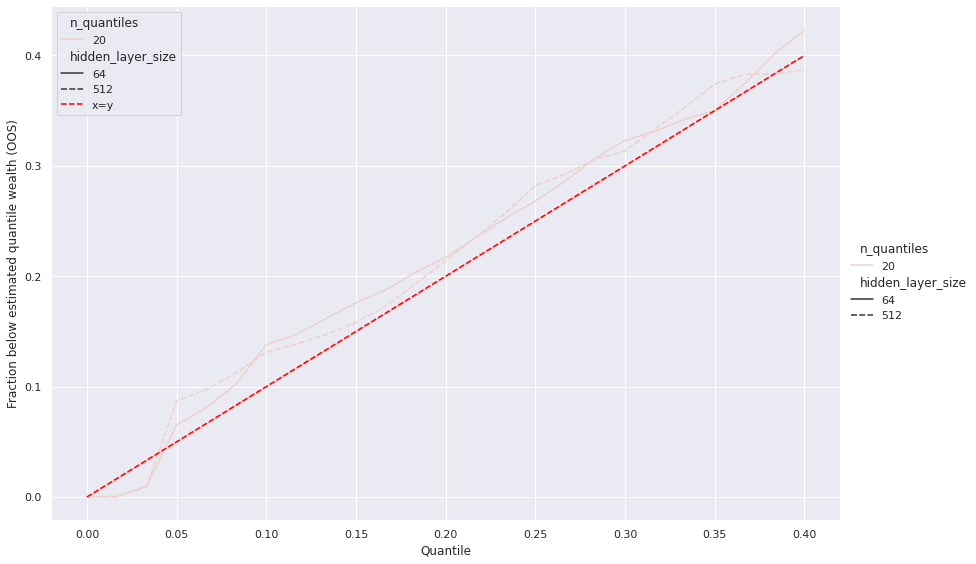

In [17]:
to_plot = quantile_rates[quantile_rates.dataset=='test']
fg = sns.relplot(
    data=to_plot, x='quantile', y='actual_below_estimated', hue='n_quantiles', 
    style='hidden_layer_size', kind='line',
    legend=True, aspect=12/8, height=8
)
for ax in fg.figure.axes:
    
    sns.lineplot(
        data=to_plot,
        x='quantile', y='quantile',
        color='red',
        linestyle='--',
        label='x=y',
        ax=ax,
        legend=True
    )
fg.set(xlabel='Quantile', ylabel='Fraction below estimated quantile wealth (OOS)')


### Clear runs from results

In [29]:
results_path = SAVE_PATH / 'gap' / 'malawi.csv'
results = pd.read_csv(results_path)

In [31]:
results[results.d != 0].to_csv(results_path, index=False)